In [1]:
import netCDF4 as nc
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import matplotlib.pyplot as plt
import urllib.request
import os
import pandas as pd
from bs4 import BeautifulSoup
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

## NC Files Data Extraction 

In [6]:
nc_file = nc.Dataset('PACE_OCI.20241010T120637.L2.OC_AOP.V2_0.NRT.nc', 'r')  # 'r' stands for read-only mode

# Access a specific group within the file
group_name = 'geophysical_data'
group = nc_file[group_name]

## Access variables within the group
Rrs_data = group.variables['Rrs'][:]  # Rrs data in geophysical_data group 184bands
Rrs_unc_data = group.variables['Rrs'][:]  # Rrs_unc data in geophysical_data group 184bands
angstrom_data = group.variables['angstrom'][:] ## Angstrom data 
aot865_data=group.variables['aot_865'][:] ## Aot_865 data
l2_flag_data=group.variables['l2_flags'][:] ## l2 flag



# Access a specific group within the file
group_name2 = 'sensor_band_parameters'
group2 = nc_file[group_name2]
## Access variables within the group
Wavelength_3d_data = group2.variables['wavelength_3d'][:]  # Wavelength_3d in sensor_band_parameters
Wavelength_1d_data = group2.variables['wavelength'][:]  # Wavelength_3d in sensor_band_parameters
F0_data = group2.variables['F0'][:]   # F0 in sensor_band_parameters
Tau_r_data = group2.variables['Tau_r'][:]   # Tau_r in sensor_band_parameters
Koz_data= group2.variables['k_oz'][:]   # K_oz in sensor_band_parameters



# Access a specific group within the file
group_name3 = 'navigation_data'
group3 = nc_file[group_name3]
LO_data=group3.variables['longitude'][:] ## LO in navigation_data
LA_data=group3.variables['latitude'][:] ## LA in navigation data

# Access a specific group within the file
group_name4 = 'scan_line_attributes'
group4 = nc_file[group_name4]
csol_z_data=group4.variables['csol_z'][:] ## LO in navigation_data

# close .nc
nc_file.close()

In [3]:
nc_file = nc.Dataset('PACE_OCI.20240531T161735.L2.OC_BGC.V1_0_0.NRT.nc', 'r')  # 'r' stands for read-only mode

# Access a specific group within the file
group_name = 'geophysical_data'
group = nc_file[group_name]

## Access variables within the group
Chlora_data = group.variables['chlor_a'][:]  # Rrs data in geophysical_data group 184bands
nc_file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'PACE_OCI.20240531T161735.L2.OC_BGC.V1_0_0.NRT.nc'

In [7]:
## Numpy array conversion
Rrs_data=np.array(Rrs_data)
Rrs_unc_data=np.array(Rrs_unc_data)
angstrom_data=np.array(angstrom_data)
aot865_data=np.array(aot865_data)
l2_flag_data=np.array(l2_flag_data)
Wavelength_3d_data=np.array(Wavelength_3d_data)
F0_data=np.array(F0_data)
LO_data=np.array(LO_data)
LA_data=np.array(LA_data)
Tau_r_data=np.array(Tau_r_data)
Koz_data=np.array(Koz_data)
csol_z_data=np.array(csol_z_data)
#Chlora_data=np.array(Chlora_data)

## Plots of geostructure and ocean color

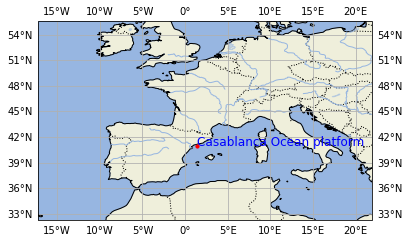

In [25]:
lat=41;lon=1.36 ## Casablanca Coordinate


## Test Geo-structure from given swath 
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([LO_data.min(), LO_data.max(), LA_data.min(), LA_data.max()], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True)

# Optionally, plot the latitude and longitude points

ax.scatter(lon, lat, color='red', s=10, transform=ccrs.PlateCarree(), zorder=5)
ax.text(lon, lat, 'Casablanca Ocean platform', transform=ccrs.PlateCarree(), fontsize=12, color='blue')
plt.savefig('20241010_Casablanca.png')

plt.show()

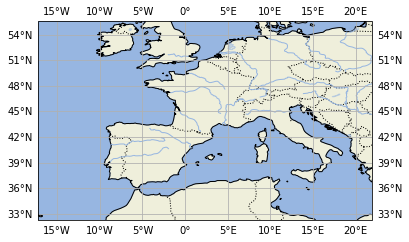

In [9]:
# Plotting chlorophyll data
#vmin = 0  # Minimum chlorophyll value for the color scale
#vmax = 10  # Maximum chlorophyll value for the color scale
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([LO_data.min(), LO_data.max(), LA_data.min(), LA_data.max()], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True)


#pcm = ax.pcolormesh(LO_data, LA_data, Chlora_data, transform=ccrs.PlateCarree(), cmap='viridis', vmin=vmin, vmax=vmax)
#fig.colorbar(pcm, ax=ax, orientation='horizontal', label='Chlorophyll Concentration (mg/m^3)')

#plt.savefig('20240531T161735_oceanColor.png')
plt.show()


## Rrs Part

In [10]:
lat=41;lon=1.36 ## Casablanca Coordinate

L=np.abs((LA_data-lat))+np.abs((LO_data-lon))

L.shape

(1710, 1272)

In [11]:
p1, q1 = np.unravel_index(np.argmin(L), L.shape) ## Indices Fiding 


l=4;                         # selecting subsampling size        
CA=LA_data[p1-l:p1+l,q1-l:q1+l]  # subsampling latitude
CO=LO_data[p1-l:p1+l,q1-l:q1+l]  # subsampling longitude


a, b = CA.shape
dist = np.zeros_like(CA)


# Assuming CA, CO, lat, and lon are NumPy arrays or matrices
# Also assuming haversine function is defined
# Initialize dist as a matrix of zeros with the same size as CA
CA_rad = np.radians(CA)
CO_rad = np.radians(CO)
lat_rad = radians(lat)
lon_rad = radians(lon)


for o in range(a):  # Loop over rows
    for rr in range(b):  # Loop over columns
        # Calculate Haversine distance between the pixel and the target location
        distv = haversine_distances([[CA_rad[o, rr], CO_rad[o, rr]]], [[lat_rad, lon_rad]])[0, 0]
        
        # Store the distance in the corresponding position in the dist matrix
        dist[o, rr] = distv   # To convert to KM (* 6371000/1000 )



In [12]:
p1,q1

(604, 356)

In [13]:
M = np.min(dist)

# Find the indices of the minimum distance in the flattened dist matrix
I_flat = np.argmin(dist)

# Convert the flattened index to row and column indices
I_row, I_col = np.unravel_index(I_flat, dist.shape)

# Calculate the row and column numbers of the closest pixel
r = p1 - l + I_row
c = q1 - l + I_col

In [14]:
r,c

(604, 356)

In [15]:
# Test the pixel distance from the ideal location 
LA=np.radians(LA_data)
LO=np.radians(LO_data)
pixel_distance = haversine_distances([[LA[r, c], LO[r, c]]], [[lat_rad, lon_rad]])[0, 0]
pixel_distance_KM=pixel_distance * 6371000/1000 
print('Pixel Distance:',pixel_distance_KM)


Pixel Distance: 0.17399660823804056


In [16]:
## 1.2Km 1x1 grid
Rrs_0=Rrs_data[r,c,:]
L2_flag_0=l2_flag_data[r,c]
aot865_0=aot865_data[r,c]
angstrom_0=angstrom_data[r,c]


In [17]:
# 3.6Km 3x3 grid
## Question for Eder: why calculate the mean and std
px=1
Rrs_1=Rrs_data[r-px:r+px+1,c-px:c+px+1,:]
L2_flag_1=l2_flag_data[r-px:r+px,c-px:c+px]
aot865_1=aot865_data[r-px:r+px,c-px:c+px]
angstrom_1=angstrom_data[r-px,c+px]
## Question for Eder

In [18]:
# 6Km 5x5 grid
## Question for Eder: why calculate the mean and std
px=2
Rrs_2=Rrs_data[r-px:r+px+1,c-px:c+px+1,:]
L2_flag_2=l2_flag_data[r-px:r+px,c-px:c+px]
aot865_2=aot865_data[r-px:r+px,c-px:c+px]
angstrom_2=angstrom_data[r-px,c+px]
## Question for Eder

In [19]:
# 8.4Km 7x7 grid
## Question for Eder: why calculate the mean and std
px=4
Rrs_3=Rrs_data[r-px:r+px+1,c-px:c+px+1,:]
L2_flag_3=l2_flag_data[r-px:r+px,c-px:c+px]
aot865_3=aot865_data[r-px:r+px,c-px:c+px]
angstrom_3=angstrom_data[r-px,c+px]


Replace Nan before plotting

In [20]:
## If using Grid data, replace Nan first 
Rrs_1[Rrs_1 < 0 ] = np.nan

mean_rrs = np.nanmean(Rrs_1, axis=(0, 1))



<ipython-input-20-3d9098653358>:4: RuntimeWarning: Mean of empty slice
  mean_rrs = np.nanmean(Rrs_1, axis=(0, 1))


In [21]:
np.min(mean_rrs)

nan

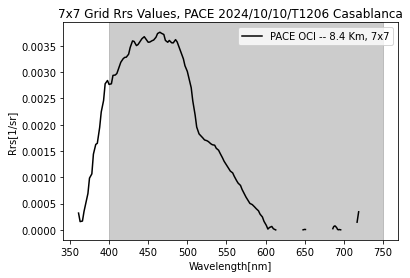

In [24]:
plt.plot(Wavelength_3d_data,mean_rrs,label='PACE OCI -- 8.4 Km, 7x7',color='black')
plt.axvspan(400, 750, color='gray', alpha=0.4)
plt.xlabel('Wavelength[nm]')
plt.ylabel('Rrs[1/sr]')
plt.title('7x7 Grid Rrs Values, PACE 2024/10/10/T1206 Casablanca')
plt.legend()
plt.savefig('Casablanca.png')

Below are ARONET DATA extraction and Matching up with PACE mission Data 

In [26]:
## HTML ARONET Site File Data Extraction

# Read HTML file
with open('AERONET Data Download (Version 3 SEAPRISM Processing).html', 'r') as file:
    html_content = file.read()
soup = BeautifulSoup(html_content, 'html.parser')

# Find all text-containing elements in the HTML
text_elements = soup.find_all(text=True)

# Extract text content from each element and filter out empty strings
text_content = [element.strip() for element in text_elements if element.strip()]

# If there's any text content, print it
if text_content:
    # Print the extracted text content
    for text in text_content:
        print(text)
else:
    print("No text content found in the HTML.")

text_content=np.array(text_content)

AERONET Data Download (Version 3 SEAPRISM Processing)
AERONET Data Download (Version 3 SEAPRISM Processing)
AERONET Version 3;
Version 3: Lwn Level 1.5,
The following data are cloud cleared and quality controls have been applied but these data may not have final calibration applied.  These data may change.
Contact: PI=Marco_Talone_and_Frederic_Melin; PI Email=talone@icm.csic.es_and_frederic.melin@ec.europa.eu
AERONET_Site,Date(dd-mm-yyyy),Time(hh:mm:ss),Day_of_Year,Day_of_Year(Fraction),Solar_Zenith_Angle[340nm],Solar_Zenith_Angle[380nm],Solar_Zenith_Angle[400nm],Solar_Zenith_Angle[412nm],Solar_Zenith_Angle[440nm],Solar_Zenith_Angle[443nm],Solar_Zenith_Angle[490nm],Solar_Zenith_Angle[500nm],Solar_Zenith_Angle[510nm],Solar_Zenith_Angle[531nm],Solar_Zenith_Angle[532nm],Solar_Zenith_Angle[551nm],Solar_Zenith_Angle[555nm],Solar_Zenith_Angle[560nm],Solar_Zenith_Angle[620nm],Solar_Zenith_Angle[667nm],Solar_Zenith_Angle[675nm],Solar_Zenith_Angle[681nm],Solar_Zenith_Angle[709nm],Solar_Zenith_A

In [27]:
## Here text_content[6] leads to Header Infomation


AERNOT_Specific_Data = text_content[7:]   
header_info = np.array(text_content[6].split(','))
AERNOT_Specific_Data = np.array([element.split(',') for element in AERNOT_Specific_Data])   ## Shape is (15,553) specificed


In [28]:
header_info

array(['AERONET_Site', 'Date(dd-mm-yyyy)', 'Time(hh:mm:ss)',
       'Day_of_Year', 'Day_of_Year(Fraction)',
       'Solar_Zenith_Angle[340nm]', 'Solar_Zenith_Angle[380nm]',
       'Solar_Zenith_Angle[400nm]', 'Solar_Zenith_Angle[412nm]',
       'Solar_Zenith_Angle[440nm]', 'Solar_Zenith_Angle[443nm]',
       'Solar_Zenith_Angle[490nm]', 'Solar_Zenith_Angle[500nm]',
       'Solar_Zenith_Angle[510nm]', 'Solar_Zenith_Angle[531nm]',
       'Solar_Zenith_Angle[532nm]', 'Solar_Zenith_Angle[551nm]',
       'Solar_Zenith_Angle[555nm]', 'Solar_Zenith_Angle[560nm]',
       'Solar_Zenith_Angle[620nm]', 'Solar_Zenith_Angle[667nm]',
       'Solar_Zenith_Angle[675nm]', 'Solar_Zenith_Angle[681nm]',
       'Solar_Zenith_Angle[709nm]', 'Solar_Zenith_Angle[779nm]',
       'Solar_Zenith_Angle[865nm]', 'Solar_Zenith_Angle[870nm]',
       'Solar_Zenith_Angle[1020nm]', 'Solar_Zenith_Angle[Empty]',
       'Solar_Zenith_Angle[Empty]', 'Solar_Zenith_Angle[Empty]',
       'Solar_Zenith_Angle[Empty]', 'Solar_Zen

In [29]:
def extract_column_values(array, column_index):

    return array[:, column_index]

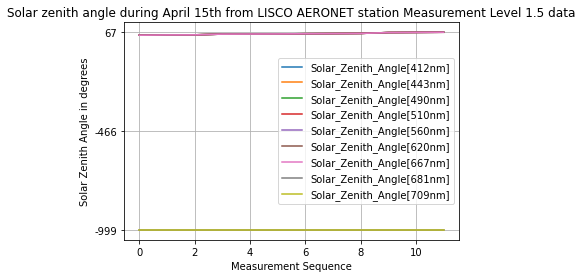

In [31]:
# Solar Zenith Angle at different wavelength as ARENOT plot presents
target_headers = np.array(["Solar_Zenith_Angle[412nm]", "Solar_Zenith_Angle[443nm]", "Solar_Zenith_Angle[490nm]", "Solar_Zenith_Angle[510nm]", "Solar_Zenith_Angle[560nm]","Solar_Zenith_Angle[620nm]","Solar_Zenith_Angle[667nm]","Solar_Zenith_Angle[681nm]","Solar_Zenith_Angle[709nm]"])
# Find indices of target headers
indices_solar_z_angle = np.where(header_info == np.array(target_headers)[:, None])[1]

# extrac values 
raw=extract_column_values(AERNOT_Specific_Data,indices_solar_z_angle)
# Solar zenith angle values are stored for all wavelengths as reported as website, each column represents a specific wavelength 
solar_z_angle_column_arrays = [raw[:, i] for i in range(raw.shape[1])]   
solar_z_angle_column_arrays=np.array(solar_z_angle_column_arrays)
solar_z_angle_column_arrays=solar_z_angle_column_arrays.astype(float)

## Plot Function
for i, column_array in enumerate(solar_z_angle_column_arrays):
    plt.plot(column_array, label=target_headers[i])

# Add labels and legend
plt.xlabel('Measurement Sequence')
plt.ylabel('Solar Zenith Angle in degrees')
plt.title('Solar zenith angle during April 15th from LISCO AERONET station Measurement Level 1.5 data')
plt.legend()
plt.grid(True)

min_value = np.min(solar_z_angle_column_arrays)
max_value = np.max(solar_z_angle_column_arrays)
mid_value = (min_value + max_value) / 2
plt.yticks([min_value, mid_value, max_value], [round(min_value), round(mid_value), round(max_value)])

#plt.savefig('SZA.png')
# Show plot
plt.show()
solar_z_angle_elements_Fixed_Time = solar_z_angle_column_arrays[:, -1]

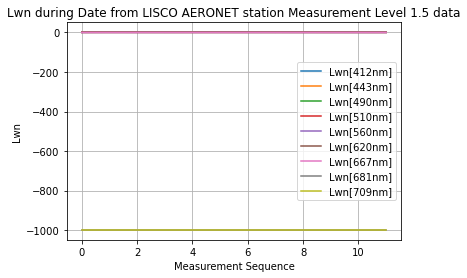

In [33]:
# Lwn at different wavelength as ARENOT plot presents
target_headers = np.array(["Lwn[412nm]", "Lwn[443nm]", "Lwn[490nm]", "Lwn[510nm]", "Lwn[560nm]","Lwn[620nm]","Lwn[667nm]","Lwn[681nm]","Lwn[709nm]"])
# Find indices of target headers
indices_Lwn = np.where(header_info == np.array(target_headers)[:, None])[1]

# extrac values 
raw1=extract_column_values(AERNOT_Specific_Data,indices_Lwn)
# Solar zenith angle values are stored for all wavelengths as reported as website, each column represents a specific wavelength 
Lwn_column_arrays = [raw1[:, i] for i in range(raw1.shape[1])]   
Lwn_column_arrays=np.array(Lwn_column_arrays)
Lwn_column_arrays=Lwn_column_arrays.astype(float)

## Plot Function
for i, column_array in enumerate(Lwn_column_arrays):
    plt.plot(column_array, label=target_headers[i])

# Add labels and legend
plt.xlabel('Measurement Sequence')
plt.ylabel('Lwn')
plt.title('Lwn during Date from LISCO AERONET station Measurement Level 1.5 data')
plt.legend()
plt.grid(True)


#plt.savefig('Lwn.png')
# Show plot
plt.show()


## change [:,-1] to get desired time measurement of AERONET
Lwn_elements_Fixed_Time = Lwn_column_arrays[:, -1]

In [34]:
## Locate Wavelength in .nc file variables

target_lambda_headers = np.array([413, 442, 490, 510, 560, 620, 667, 681, 709])
# Find indices of target headers
indices_lambda = np.where(Wavelength_1d_data == np.array(target_lambda_headers)[:, None])[1]


In [35]:
## Mean Solar Flux [W.m^-2 um^-1]
F0_specificed=F0_data[indices_lambda]
F0_specificed

array([1772.68  , 1907.95  , 1954.7   , 1965.2001, 1842.84  , 1689.4   ,
       1544.01  , 1499.05  , 1397.05  ], dtype=float32)

In [36]:
Rrs_AERONET=(Lwn_elements_Fixed_Time/(F0_specificed))*10

In [37]:

plot_indices=np.where(Wavelength_3d_data == np.array(target_lambda_headers)[:, None])[1]


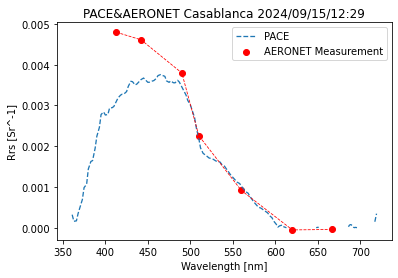

In [39]:
plt.plot(Wavelength_3d_data, mean_rrs, linestyle='--', linewidth=1.3, label='PACE')
# Plot array2 with respect to specific indices of alpha

#plt.scatter([Wavelength_3d_data[i] for i in plot_indices], Rrs_AERONET, color='red', label='AERONET Measurement')
#plt.plot([Wavelength_3d_data[i] for i in plot_indices], Rrs_AERONET, linestyle='--', color='red', linewidth=0.8, marker='.')


plt.scatter([Wavelength_3d_data[i] for i in plot_indices[:-2]], Rrs_AERONET[:-2], color='red', label='AERONET Measurement')
plt.plot([Wavelength_3d_data[i] for i in plot_indices[:-2]], Rrs_AERONET[:-2], linestyle='--', color='red', linewidth=0.8, marker='.')

plt.ylabel('Rrs [Sr^-1]')
plt.xlabel('Wavelength [nm]')
plt.title('PACE&AERONET Casablanca 2024/09/15/12:29')
plt.legend()
plt.savefig('casaMatch.png')
plt.show()


MATCHING USING Tau_r data

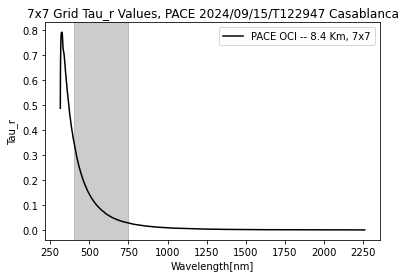

In [40]:
plt.plot(Wavelength_1d_data,Tau_r_data,label='PACE OCI -- 8.4 Km, 7x7',color='black')
plt.axvspan(400, 750, color='gray', alpha=0.4)
plt.xlabel('Wavelength[nm]')
plt.ylabel('Tau_r')
plt.title('7x7 Grid Tau_r Values, PACE 2024/09/15/T122947 Casablanca')
plt.legend()
#plt.savefig('Casablanca.png')

## Interp Values on 3d wavelength data range

In [41]:
from scipy.interpolate import interp1d

interp_func_1 = interp1d(Wavelength_1d_data, Tau_r_data, kind='linear', fill_value="extrapolate")
# Interpolate the values at the points in wavelength_3d data
Tau_r_data_lambda3D_data = interp_func_1(Wavelength_3d_data)

tauC = np.zeros_like(Tau_r_data_lambda3D_data)  

for i in range(184):
    if i < 62:
        tauC[i] = Tau_r_data_lambda3D_data[i] - 0.045 * Tau_r_data_lambda3D_data[i] * (490 - Wavelength_3d_data[i]) / (490 - 339)
    else:
        tauC[i] = Wavelength_3d_data[i]

# Transpose tauC to match MATLAB's behavior (if needed)
tauR = tauC  

In [42]:
interp_func_2 = interp1d(Wavelength_1d_data, Koz_data, kind='linear', fill_value="extrapolate")
# Interpolate the values at the points in wavelength_3d data
Tau_oz_data_3d = interp_func_2(Wavelength_3d_data) * 0.3

interp_func_3 = interp1d(Wavelength_1d_data, F0_data/10, kind='linear', fill_value="extrapolate")
# Interpolate the values at the points in wavelength_3d data
F00_data = interp_func_3(Wavelength_3d_data) 

## csol & Solzo data interp

In [43]:
## use r,c coordinate to performe interp
csol_z_data.shape

SolZ= csol_z_data[c]

SenZ = np.degrees(np.arctan(np.abs(1272/2 - r) * 1.2 / 676.5))

## r,c coordinate aot interp
aot865_intrp = aot865_0 * (865.0 / Wavelength_3d_data) ** angstrom_0


In [44]:
Lr = F00_data * tauR * 0.75 * (1 + (np.cos(np.radians(SolZ))**2) * (np.cos(np.radians(SenZ))**2)) / (4 * np.pi * np.cos(np.radians(SenZ)))

# Compute Lr1
Lr1 = F00_data * tauR * 0.75 * (1 + (np.cos(np.radians(SolZ))**2) * (np.cos(np.radians(SenZ))**2)) / (4 * np.pi * np.cos(np.radians(SenZ)))

# Compute t0 (sun to surface)
t0 = np.exp(-((tauR / 2 + Tau_oz_data_3d) / np.cos(np.radians(SolZ))))

# Compute Ed
Ed = F00_data * t0 * np.cos(np.radians(SolZ))

# Compute La
La = F00_data * aot865_intrp * 0.15 / (4 * np.pi * np.cos(np.radians(SenZ)))

# Compute t (surface to TOA)
t = np.exp(-((tauR / 2 + Tau_oz_data_3d) / np.cos(np.radians(SenZ))))

In [45]:
# Compute S1
S1 = (Lr1 - Lr) / Ed / t

# Compute S
S = Lr / Ed

# Define wl2 array
wl2 = np.array([400, 412, 443, 490, 510, 560, 620, 667])

In [46]:
# Assuming Rrs, rV, and cV are already defined as arrays
RrsL0 = Rrs_data[r, c,:]

# Compute RrsL
RrsL = Rrs_data[r, c,:] + S1


In [47]:
#Lt = Lr + La + t * (RrsL0 * Ed)

#for i in range(184):
    #if i < 62:
        #Lt[i] = Lt[i] + 0.025 * Lt[i] * (490 - Wavelength_3d_data[i]) / (490 - 339)


#RrsL2 = (Lt - Lr - La) / Ed / t
#RrsL2 = np.nan_to_num(RrsL2, nan=0.0, posinf=1e10, neginf=-1e10)

In [48]:
X1 = np.abs(Rrs_data[r, c, 43] / Rrs_data[r, c, 86])
X2 = np.abs(Rrs_data[r, c, 60] / Rrs_data[r, c, 86])

# Calculate the maximum of X1 and X2 element-wise
X = np.log10(np.maximum(X1, X2))

In [49]:
# Coefficients
a0 = 0.2228
a1 = -2.4683
a2 = 1.5867
a3 = -0.4275
a4 = -0.7768

# Assuming X is already defined as a NumPy array
chlV2 = 10 ** (a0 + a1 * X + a2 * X**2 + a3 * X**3 + a4 * X**4)


In [50]:
#Wavelength_3d_data.shape
RrsL.shape

(184,)

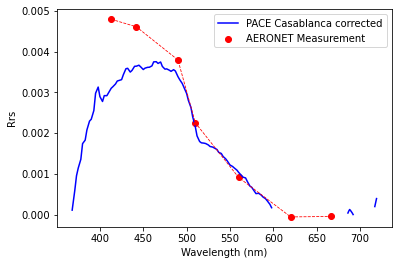

In [52]:
#plt.plot(Wavelength_3d_data, RrsL0, 'b', label='PACE Casablanca')  # Dashed blue line
plt.plot(Wavelength_3d_data, RrsL, 'blue', label='PACE Casablanca corrected')  # Red line
#plt.plot(wl2, Rrs_AERONET[:-2], '*k', label='Casablanca station')  # Black stars
plt.scatter([Wavelength_3d_data[i] for i in plot_indices[:-2]], Rrs_AERONET[:-2], color='red', label='AERONET Measurement')
plt.plot([Wavelength_3d_data[i] for i in plot_indices[:-2]], Rrs_AERONET[:-2], linestyle='--', color='red', linewidth=0.8, marker='.')

# Add legend
plt.legend()



# Add labels for clarity (optional)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Rrs')
plt.savefig('CasablancaCorrected.png')
# Show the plot
plt.show()


Mean of array1: 0.0021084959406663874
Mean of array2: 0.002082137856632471
Standard deviation of array1: 0.0012641529646097638
Standard deviation of array2: 0.0012769787572324276
Pearson correlation: 0.9583579959554233
T-test: t-statistic = 0.14668852103197982, p-value = 0.8835256345068234


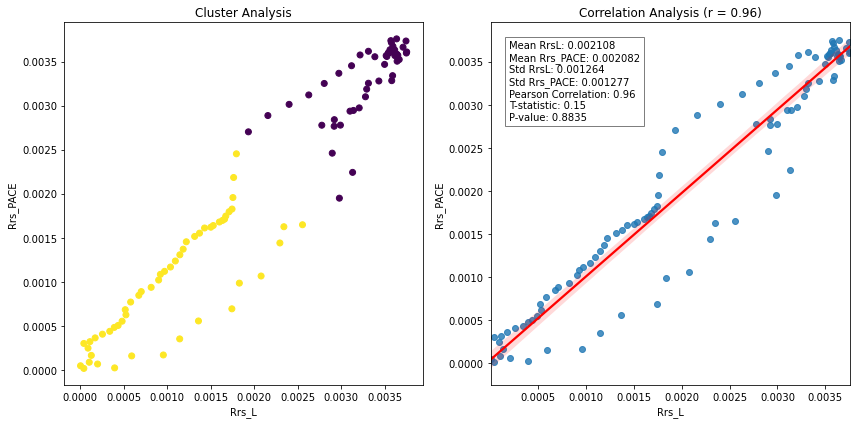

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import seaborn as sns

# Example arrays with NaN values
array1 = RrsL
array2 = mean_rrs

# Clean the arrays by removing NaN and inf values
array1_clean = array1[~np.isnan(array1) & ~np.isinf(array1)]
array2_clean = array2[~np.isnan(array2) & ~np.isinf(array2)]



# Ensuring both arrays have the same length after cleaning
min_length = min(len(array1_clean), len(array2_clean))
array1_clean = array1_clean[:min_length]
array2_clean = array2_clean[:min_length]

# Descriptive statistics
mean1 = np.mean(array1_clean)
mean2 = np.mean(array2_clean)

std1 = np.std(array1_clean)
std2 = np.std(array2_clean)

# Correlation
correlation, _ = stats.pearsonr(array1_clean, array2_clean)

# T-test
t_stat, p_val = stats.ttest_ind(array1_clean, array2_clean)

# Displaying the results
print(f"Mean of array1: {mean1}")
print(f"Mean of array2: {mean2}")
print(f"Standard deviation of array1: {std1}")
print(f"Standard deviation of array2: {std2}")
print(f"Pearson correlation: {correlation}")
print(f"T-test: t-statistic = {t_stat}, p-value = {p_val}")



# Ensuring both arrays have the same length after cleaning
min_length = min(len(array1_clean), len(array2_clean))
array1_clean = array1_clean[:min_length]
array2_clean = array2_clean[:min_length]

# Reshape for KMeans clustering (KMeans expects a 2D array)
data = np.vstack((array1_clean, array2_clean)).T

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
labels = kmeans.labels_

# Correlation analysis
correlation, _ = stats.pearsonr(array1_clean, array2_clean)

# Plot cluster analysis
plt.figure(figsize=(12, 6))

# Scatter plot with cluster labels
plt.subplot(1, 2, 1)
plt.scatter(array1_clean, array2_clean, c=labels, cmap='viridis')
plt.title('Cluster Analysis')
plt.xlabel('Rrs_L')
plt.ylabel('Rrs_PACE')

# Plot correlation
plt.subplot(1, 2, 2)
sns.regplot(x=array1_clean, y=array2_clean, line_kws={"color": "red"})
plt.title(f'Correlation Analysis (r = {correlation:.2f})')
plt.xlabel('Rrs_L')
plt.ylabel('Rrs_PACE')

# Add descriptive stats and t-test values to the cluster plot
plt.text(0.05, 0.95, f'Mean RrsL: {mean1:.6f}\nMean Rrs_PACE: {mean2:.6f}\nStd RrsL: {std1:.6f}\nStd Rrs_PACE: {std2:.6f}\nPearson Correlation: {correlation:.2f}\nT-statistic: {t_stat:.2f}\nP-value: {p_val:.4f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))



# Show plots
plt.tight_layout()
plt.savefig('analysis.png')
plt.show()


#Compare available wave bands if needed

In [68]:
# Last value is Nan, revise as needed
target_headers_comparison=indices_lambda[:-1]
PACE_rrs_Available_bands=mean_rrs[target_headers_comparison]
Rrs_AERONET_Available_Bands=Rrs_AERONET[-1]
PACE_rrs_Available_bands_Corrected=RrsL[-1]
